In [2]:
!pip install 'statsmodels<=0.12.1'
!pip install sktime

https://towardsdatascience.com/dont-use-k-fold-validation-for-time-series-forecasting-30b724aaea64

https://www.sktime.org/en/stable/examples/01_forecasting.html

In [3]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcb7903fd50>)

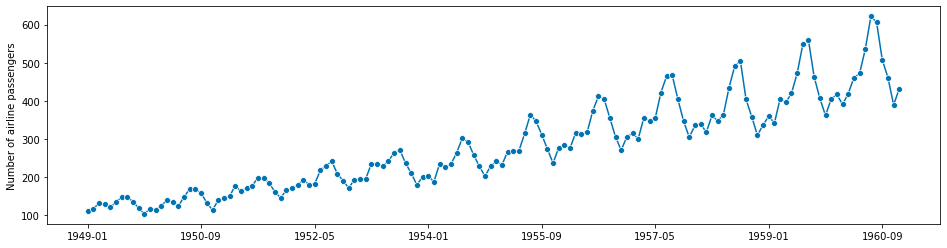

In [4]:
y = load_airline()
plot_series(y)

In [5]:
import numpy as np
import pandas as pd

In [6]:
type(y), y.shape

(pandas.core.series.Series, (144,))

In [7]:
y[-10:]

1960-03    419.0
1960-04    461.0
1960-05    472.0
1960-06    535.0
1960-07    622.0
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, dtype: float64

In [8]:
fh = np.arange(1, 37)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

In [9]:
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("1961-01", periods=36, freq="M")), is_relative=False
)
fh


ForecastingHorizon(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12',
             '1962-01', '1962-02', '1962-03', '1962-04', '1962-05', '1962-06',
             '1962-07', '1962-08', '1962-09', '1962-10', '1962-11', '1962-12',
             '1963-01', '1963-02', '1963-03', '1963-04', '1963-05', '1963-06',
             '1963-07', '1963-08', '1963-09', '1963-10', '1963-11', '1963-12'],
            dtype='period[M]', freq='M', is_relative=False)

In [10]:
cutoff = pd.Period("1960-12", freq="M")
fh.to_relative(cutoff)
fh

ForecastingHorizon(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12',
             '1962-01', '1962-02', '1962-03', '1962-04', '1962-05', '1962-06',
             '1962-07', '1962-08', '1962-09', '1962-10', '1962-11', '1962-12',
             '1963-01', '1963-02', '1963-03', '1963-04', '1963-05', '1963-06',
             '1963-07', '1963-08', '1963-09', '1963-10', '1963-11', '1963-12'],
            dtype='period[M]', freq='M', is_relative=False)

In [11]:
from sktime.forecasting.naive import NaiveForecaster
fc = NaiveForecaster(strategy="last")


In [12]:
fc.fit(y)


NaiveForecaster()

In [13]:
y_pred = fc.predict(fh)


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcb763e2390>)

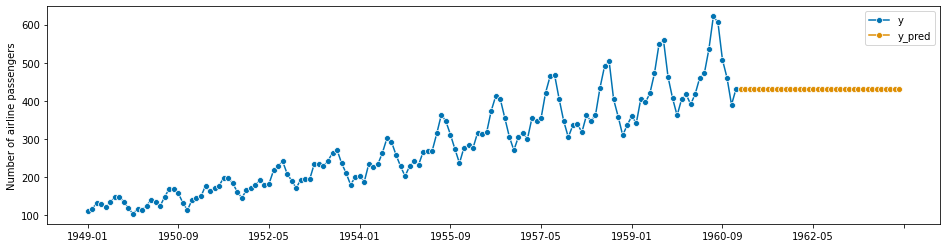

In [14]:

plot_series(y, y_pred, labels=["y", "y_pred"])

In [15]:
from sktime.forecasting.theta import ThetaForecaster

In [16]:
fc = ThetaForecaster(sp=12)
fc.fit(y)

ThetaForecaster(sp=12)

In [17]:
alpha = 0.3  # 2.5%/97.5% prediction intervals
y_pred, y_pred_ints = fc.predict(fh, return_pred_int=True, alpha=alpha)

/usr/local/lib/python3.7/dist-packages/sktime/forecasting/base/_base.py:220: FutureWarning: return_pred_int in predict() will be deprecated;please use predict_interval() instead to generate prediction intervals.
  FutureWarning,


In [18]:
y_pred_ints.head()


,lower,upper
1961-01,426.788004,455.774068
1961-02,412.327315,446.776621
1961-03,471.459507,510.617105
1961-04,455.315468,498.673055
1961-05,457.374654,504.559853


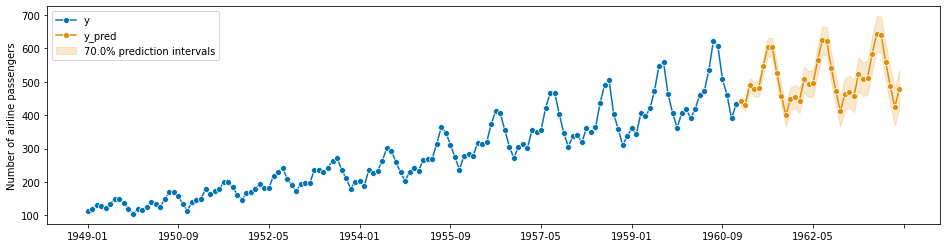

In [19]:
fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints["lower"],
    y_pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{100*(1 - alpha)}% prediction intervals",
)
ax.legend();

In [20]:
from sktime.forecasting.model_selection import temporal_train_test_split



In [21]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
# we will try to forecast y_test from y_train

108 36


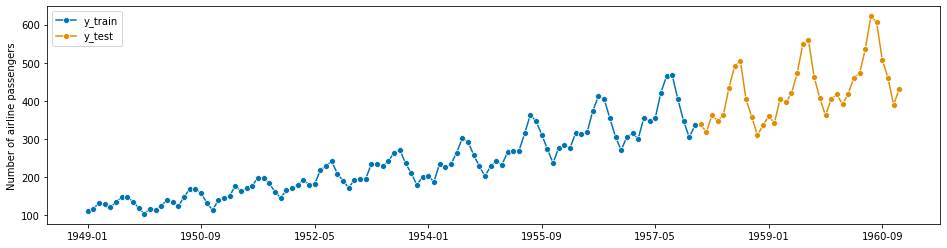

In [22]:
# plotting for illustration
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [23]:
# we can simply take the indices from `y_test` where they already are stored
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy="last", sp=12)

forecaster.fit(y_train)

# y_pred will contain the predictions
y_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcb762fb7d0>)

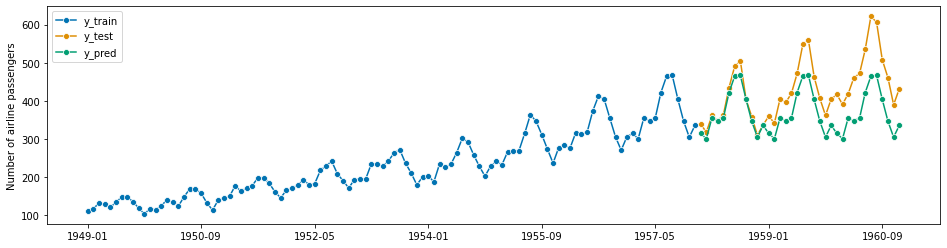

In [24]:
# plotting for illustration
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [25]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [26]:
# option 1: using the lean function interface
mean_absolute_percentage_error(y_test, y_pred)
# note: the FIRST argument is the ground truth, the SECOND argument are the forecasts
#       the order matters for most metrics in general

0.145427686270316

In [27]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [28]:
# option 2: using the composable class interface
mape = MeanAbsolutePercentageError(symmetric=False)
# the class interface allows to easily construct variants of the MAPE
#  e.g., the non-symmetric verion
# it also allows for inspection of metric properties
#  e.g., are higher values better (answer: no)?
mape.greater_is_better

False

In [29]:
# evaluation works exactly like in option 2, but with the instantiated object
mape(y_test, y_pred)

0.13189432350948402

In [30]:
from sktime.registry import all_estimators

In [31]:
all_estimators("forecaster", as_dataframe=True)

/usr/local/lib/python3.7/dist-packages/sktime/registry/_lookup.py:156: ImportWarning: No module named 'esig'. 'esig' is a soft dependency and not included in the sktime installation. Please run: `pip install esig`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)
/usr/local/lib/python3.7/dist-packages/sktime/registry/_lookup.py:156: ImportWarning: No module named 'pmdarima'. 'pmdarima' is a soft dependency and not included in the sktime installation. Please run: `pip install pmdarima`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)
/usr/local/lib/python3.7/dist-packages/sktime/registry/_lookup.py:156: ImportWarning: No module named 'tbats'. 'tbats' is a soft dependency and not included in the sktime installation. Please run: `pip install tbats`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)
/usr/lo

,name,estimator
0,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
1,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
2,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
3,Croston,<class 'sktime.forecasting.croston.Croston'>
4,DirRecTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
5,DirRecTimeSeriesRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
6,DirectTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
7,DirectTimeSeriesRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
8,EnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.E...
9,ExponentialSmoothing,<class 'sktime.forecasting.exp_smoothing.Expon...


In [32]:
from sktime.datasets import load_airline
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series

In [33]:
y = load_airline()
y_1957Dec = y[:-36]

# step 1: specifying the forecasting strategy
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

# step 2: specifying the forecasting horizon: one year ahead, all months
fh = np.arange(1, 13)

# step 3: this is the first time we use the model, so we fit it
forecaster.fit(y_1957Dec)

# step 4: obtaining the first batch of forecasts for Jan 1958 - Dec 1958
y_pred_1957Dec = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcb6a6f8150>)

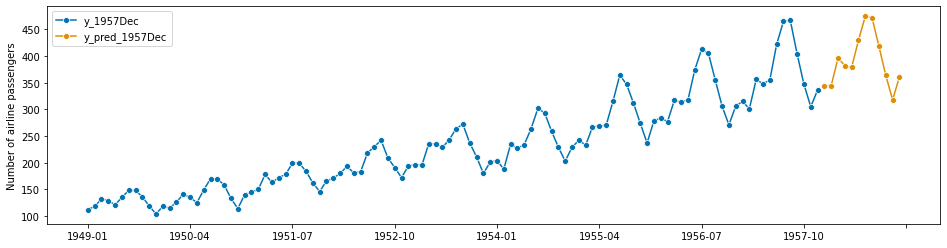

In [34]:
plot_series(y_1957Dec, y_pred_1957Dec, labels=["y_1957Dec", "y_pred_1957Dec"])

In [35]:
# new data is observed:
y_1958Jan = y[[-36]]

# step 5: we update the forecaster with the new data
forecaster.update(y_1958Jan)

# step 6: making forecasts with the updated data
y_pred_1958Jan = forecaster.predict(fh)

/usr/local/lib/python3.7/dist-packages/sktime/forecasting/base/_base.py:1098: UserWarning:




In [36]:
y_pred_1958Jan

1958-02    341.515296
1958-03    392.850194
1958-04    378.521674
1958-05    375.664269
1958-06    426.013436
1958-07    470.581055
1958-08    467.112569
1958-09    414.462858
1958-10    360.966267
1958-11    315.213058
1958-12    357.911171
1959-01    363.050545
Freq: M, dtype: float64

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcb6a5cabd0>)

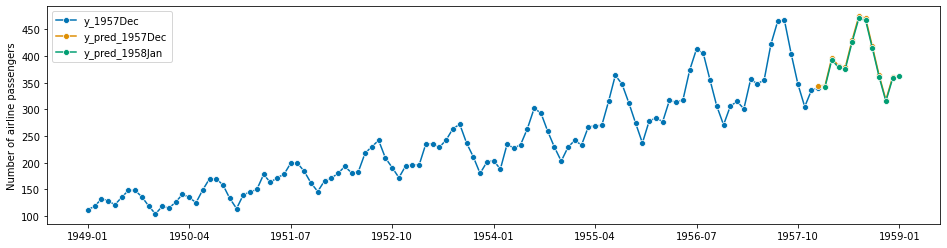

In [37]:
plot_series(
    y[:-35],
    y_pred_1957Dec,
    y_pred_1958Jan,
    labels=["y_1957Dec", "y_pred_1957Dec", "y_pred_1958Jan"],
)


In [38]:
# February 1958

# new data is observed:
y_1958Feb = y[[-35]]

# step 5: we update the forecaster with the new data
forecaster.update(y_1958Feb)

# step 6: making forecasts with the updated data
y_pred_1958Feb = forecaster.predict(fh)

/usr/local/lib/python3.7/dist-packages/sktime/forecasting/base/_base.py:1098: UserWarning:




(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcb6a6d9450>)

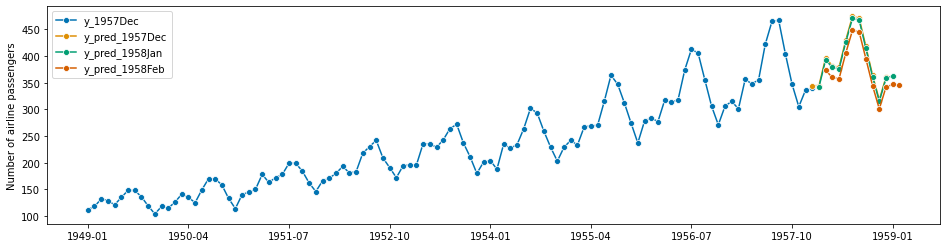

In [39]:
# plotting predictions and past data
plot_series(
    y[:-35],
    y_pred_1957Dec,
    y_pred_1958Jan,
    y_pred_1958Feb,
    labels=["y_1957Dec", "y_pred_1957Dec", "y_pred_1958Jan", "y_pred_1958Feb"],
)



In [40]:
# March 1958

# new data is observed:
y_1958Mar = y[[-34]]

# step 5&6: update/predict in one step
forecaster.update_predict_single(y_1958Mar, fh=fh)


/usr/local/lib/python3.7/dist-packages/sktime/forecasting/base/_base.py:1098: UserWarning:




1958-04    349.163637
1958-05    346.921272
1958-06    394.057057
1958-07    435.847486
1958-08    433.324372
1958-09    384.851188
1958-10    335.542810
1958-11    293.179886
1958-12    333.282336
1959-01    338.600757
1959-02    336.986846
1959-03    388.124340
Freq: M, dtype: float64

In [41]:
# April 1958

# new data is observed:
y_1958Apr = y[[-33]]

# step 5: perform an update without re-computing the model parameters
forecaster.update(y_1958Apr, update_params=False)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [60]:
!pip install pmdarima
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter

In [43]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

cv = ExpandingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72
)

df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

,cutoff,fit_time,len_train_window,pred_time,test_MeanAbsolutePercentageError
0,1954-12,4.930998,72,0.011340,0.064381
1,1955-12,5.778690,84,0.009760,0.051731
2,1956-12,8.025277,96,0.007259,0.030455
3,1957-12,3.558549,108,0.006806,0.052028
4,1958-12,5.335769,120,0.008606,0.076921
5,1959-12,11.679662,132,0.010500,0.030936


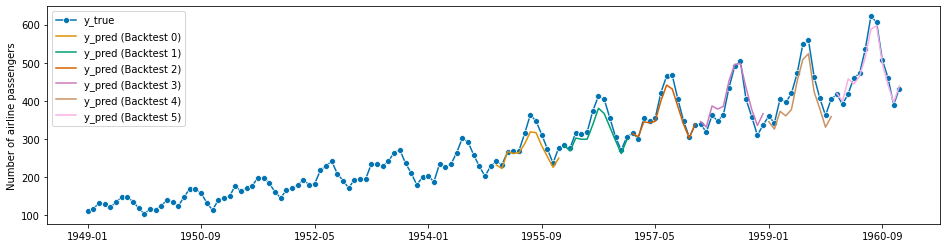

In [44]:
# visualization of a forecaster evaluation
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

In [105]:
# imports necessary for this chapter
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

y1 = pd.read_csv('CDPROJEKT.mst')
y = y1[['<CLOSE>']]
# data loading for illustration (see section 1 for explanation)
y.tail(10)
# Stopa zwrotu: log(C[t]) - log(C[t-1]) = log(C[t]/C[t-1])
# Srednie kroczace!

,<CLOSE>
6775,183.00
6776,179.94
6777,181.34
6778,189.00
6779,194.48
6780,201.00
6781,186.54
6782,187.08
6783,185.52
6784,191.52


In [47]:
y1 ['Stopa zwrotu'] = '0'

In [48]:
y1 ['Srednia kroczaca'] = '0'

In [106]:
y1

,<TICKER>,<DTYYYYMMDD>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,CDPROJEKT,19940802,40.00,40.00,40.00,40.00,71824
1,CDPROJEKT,19940803,44.00,44.00,44.00,44.00,67228
2,CDPROJEKT,19940804,48.40,48.40,48.40,48.40,73432
3,CDPROJEKT,19940808,44.00,44.00,44.00,44.00,54500
4,CDPROJEKT,19940809,52.00,52.00,52.00,52.00,27962
...,...,...,...,...,...,...,...
6780,CDPROJEKT,20211123,194.00,201.00,190.40,201.00,959888
6781,CDPROJEKT,20211124,199.88,201.00,186.50,186.54,556521
6782,CDPROJEKT,20211125,189.00,190.98,185.18,187.08,194865
6783,CDPROJEKT,20211126,185.00,186.80,181.10,185.52,553810


In [71]:
open = y1[['<OPEN>']]
close = y1[['<CLOSE>']]

In [73]:
open

,<OPEN>
0,40.00
1,44.00
2,48.40
3,44.00
4,52.00
...,...
6780,194.00
6781,199.88
6782,189.00
6783,185.00


In [74]:
close

,<CLOSE>
0,40.00
1,44.00
2,48.40
3,44.00
4,52.00
...,...
6780,201.00
6781,186.54
6782,187.08
6783,185.52


In [75]:
stopa = ((close["<CLOSE>"]/open["<OPEN>"])-1)*100

In [76]:
stopa_log = np.log(close["<CLOSE>"])/np.log(open["<OPEN>"])

In [78]:
stopa_log.tail(30)

6755    0.987698
6756    1.000263
6757    1.008271
6758    0.996705
6759    0.997452
6760    1.003455
6761    1.001747
6762    0.994555
6763    0.995941
6764    0.993248
6765    0.999755
6766    0.996925
6767    0.999754
6768    1.007730
6769    0.996613
6770    1.000194
6771    1.003536
6772    0.998391
6773    1.002405
6774    0.998542
6775    0.998955
6776    0.995204
6777    1.001514
6778    1.009395
6779    1.005453
6780    1.006729
6781    0.986962
6782    0.998052
6783    1.000538
6784    1.004566
dtype: float64

In [79]:
stopa.tail(30)

6755   -6.314741
6756    0.137712
6757    4.431518
6758   -1.725888
6759   -1.319376
6760    1.812155
6761    0.916442
6762   -2.808929
6763   -2.089979
6764   -3.441725
6765   -0.126364
6766   -1.577753
6767   -0.126568
6768    4.068498
6769   -1.747253
6770    0.100660
6771    1.849776
6772   -0.833973
6773    1.260274
6774   -0.757904
6775   -0.543478
6776   -2.471545
6777    0.789240
6778    5.000000
6779    2.899471
6780    3.608247
6781   -6.674004
6782   -1.015873
6783    0.281081
6784    2.417112
dtype: float64

In [84]:
sredniakroczaca_stopa_log = stopa_log.rolling(20).sum()

In [85]:
sredniakroczaca_stopa_log

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
6780    20.006585
6781    19.991801
6782    19.995298
6783    19.999895
6784    20.011212
Length: 6785, dtype: float64

In [86]:
sredniakroczaca_stopa = stopa.rolling(20).sum()
sredniakroczaca_stopa

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
6780    3.967137
6781   -3.623310
6782   -1.830254
6783    0.540806
6784    6.399644
Length: 6785, dtype: float64

In [87]:
sredniakroczaca_close = close.rolling(20).sum()
sredniakroczaca_close

,<CLOSE>
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
6780,3639.18
6781,3638.52
6782,3643.60
6783,3651.10


In [107]:
y1['<STOPA>'] = stopa

In [108]:
y1['<SREDNIA KROCZACA>'] = sredniakroczaca_close

In [109]:
y1

,<TICKER>,<DTYYYYMMDD>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<STOPA>,<SREDNIA KROCZACA>
0,CDPROJEKT,19940802,40.00,40.00,40.00,40.00,71824,0.000000,NaN
1,CDPROJEKT,19940803,44.00,44.00,44.00,44.00,67228,0.000000,NaN
2,CDPROJEKT,19940804,48.40,48.40,48.40,48.40,73432,0.000000,NaN
3,CDPROJEKT,19940808,44.00,44.00,44.00,44.00,54500,0.000000,NaN
4,CDPROJEKT,19940809,52.00,52.00,52.00,52.00,27962,0.000000,NaN
...,...,...,...,...,...,...,...,...,...
6780,CDPROJEKT,20211123,194.00,201.00,190.40,201.00,959888,3.608247,3639.18
6781,CDPROJEKT,20211124,199.88,201.00,186.50,186.54,556521,-6.674004,3638.52
6782,CDPROJEKT,20211125,189.00,190.98,185.18,187.08,194865,-1.015873,3643.60
6783,CDPROJEKT,20211126,185.00,186.80,181.10,185.52,553810,0.281081,3651.10


In [63]:
y_train, y_test = temporal_train_test_split(y, test_size=360)
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [64]:
y_train.shape, y_test.shape

((6425, 1), (360, 1))

In [65]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

0.5025643662384058

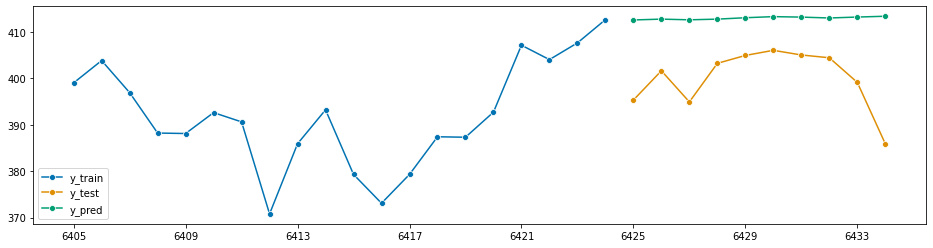

In [66]:
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train[-20:], y_test[:10], y_pred[:10], labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [67]:
from sktime.forecasting.ets import AutoETS

In [68]:
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)


0.48096759078475737

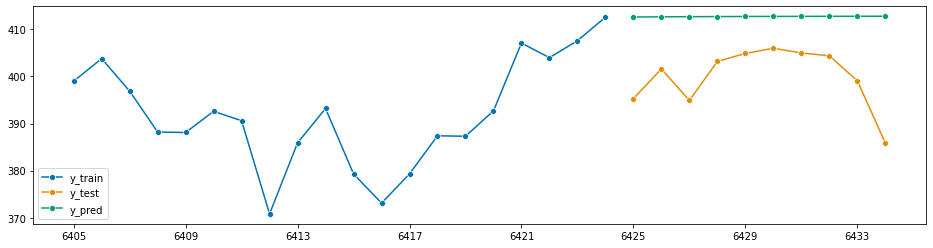

In [57]:
plot_series(y_train[-20:], y_test[:10], y_pred[:10], labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

1.0776206095602316

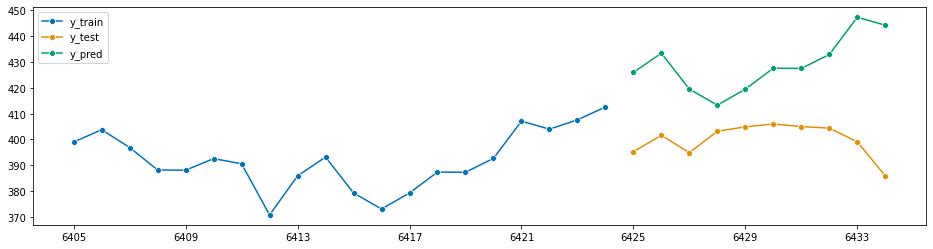

In [58]:
from sktime.forecasting.arima import ARIMA


forecaster = ARIMA(
    order=(1, 1, 0), seasonal_order=(0, 1, 0, 12), suppress_warnings=True
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train[-20:], y_test[:10], y_pred[:10], labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)



In [70]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train[-20:], y_test[:10], y_pred[:10], labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

KeyboardInterrupt: ignored

In [ ]:
# to obtain the fitted parameters, run
forecaster.get_fitted_params()

In [ ]:
!pip install tbats
from sktime.forecasting.bats import BATS

In [ ]:
forecaster = BATS(sp=12, use_trend=True, use_box_cox=False)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train[-20:], y_test[:10], y_pred[:10], labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [ ]:
from sktime.forecasting.tbats import TBATS

In [ ]:
forecaster = TBATS(sp=12, use_trend=True, use_box_cox=False)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train[-20:], y_test[:10], y_pred[:10], labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [ ]:
from sktime.forecasting.fbprophet import Prophet



In [ ]:
z = y.copy()
z = z.to_timestamp(freq="D")
z_train, z_test = temporal_train_test_split(z, test_size=36)

In [ ]:
forecaster = Prophet(
    seasonality_mode="multiplicative",
    #n_changepoints=int(len(y_train) / 12),
    add_country_holidays={"country_name": "Germany"},
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
)

forecaster.fit(z_train)
y_pred = forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))
y_pred.index = y_test.index

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [ ]:
from sktime.forecasting.structural import UnobservedComponents



In [ ]:
# We can model seasonality using Fourier modes as in the Prophet model.
forecaster = UnobservedComponents(
    level="local linear trend", freq_seasonal=[{"period": 12, "harmonics": 10}]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)